In [ ]:
# default_exp tokenization

# Tokenization

> Tokenization and SMILES utils


In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
#hide
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

In [ ]:
#export
import collections
import logging
import os
import re
import numpy as np
from rdkit import Chem

import pkg_resources

from typing import List

from transformers import BertTokenizer

## Reaction SMILES tokenizer

We use the same tokenizer as the one used for http://rxnmapper.ai.

It is an instance of [Hugginface Transformers](https://github.com/huggingface/transformers) BertTokenizer.

In [ ]:
#export
SMI_REGEX_PATTERN = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])"

def get_default_tokenizer():
    default_vocab_path = (
        pkg_resources.resource_filename(
                    "rxnfp",
                    "models/transformers/bert_ft_10k_25s/vocab.txt"
                )
    )
    return SmilesTokenizer(default_vocab_path)
    


class SmilesTokenizer(BertTokenizer):
    r"""
    Constructs a SmilesTokenizer.
    Mostly copied from https://github.com/huggingface/transformers
    Args:
        vocab_file: Path to a SMILES character per line vocabulary file
    """

    def __init__(
        self,
        vocab_file='',
        # unk_token="[UNK]",
        # sep_token="[SEP]",
        # pad_token="[PAD]",
        # cls_token="[CLS]",
        # mask_token="[MASK]",
        **kwargs
    ):
        """Constructs a BertTokenizer.
        Args:
            **vocab_file**: Path to a SMILES character per line vocabulary file
        """
        super().__init__(vocab_file, **kwargs)
        # take into account special tokens in max length
        self.max_len_single_sentence = self.max_len - 2
        self.max_len_sentences_pair = self.max_len - 3
        
        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocab file at path '{}'.".format(vocab_file)
            )
        self.vocab = load_vocab(vocab_file)
        self.highest_unused_index = max(
            [
                i for i, v in enumerate(self.vocab.keys())
                if v.startswith("[unused")
            ]
        )
        self.ids_to_tokens = collections.OrderedDict(
            [(ids, tok) for tok, ids in self.vocab.items()]
        )
        self.basic_tokenizer = BasicSmilesTokenizer()
        self.init_kwargs["max_len"] = self.max_len

    @property
    def vocab_size(self):
        return len(self.vocab)

    @property
    def vocab_list(self):
        return list(self.vocab.keys())

    def _tokenize(self, text):
        split_tokens = [token for token in self.basic_tokenizer.tokenize(text)]
        return split_tokens

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.vocab.get(token, self.vocab.get(self.unk_token))

    def _convert_id_to_token(self, index):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.ids_to_tokens.get(index, self.unk_token)

    def convert_tokens_to_string(self, tokens):
        """ Converts a sequence of tokens (string) in a single string. """
        out_string = " ".join(tokens).replace(" ##", "").strip()
        return out_string

    def add_special_tokens_ids_single_sequence(self, token_ids):
        """
        Adds special tokens to the a sequence for sequence classification tasks.
        A BERT sequence has the following format: [CLS] X [SEP]
        """
        return [self.cls_token_id] + token_ids + [self.sep_token_id]

    def add_special_tokens_single_sequence(self, tokens):
        """
        Adds special tokens to the a sequence for sequence classification tasks.
        A BERT sequence has the following format: [CLS] X [SEP]
        """
        return [self.cls_token] + tokens + [self.sep_token]

    def add_special_tokens_sequence_pair(self, token_0, token_1):
        """
        Adds special tokens to a sequence pair for sequence classification tasks.
        A BERT sequence pair has the following format: [CLS] A [SEP] B [SEP]
        """
        sep = [self.sep_token]
        cls = [self.cls_token]
        return cls + token_0 + sep + token_1 + sep

    def add_special_tokens_ids_sequence_pair(self, token_ids_0, token_ids_1):
        """
        Adds special tokens to a sequence pair for sequence classification tasks.
        A BERT sequence pair has the following format: [CLS] A [SEP] B [SEP]
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def add_padding_tokens(self, token_ids, length, right=True):
        """
        Adds padding tokens to return a sequence of length max_length.
        By  default padding tokens are added to the right of the sequence. 
        """
        padding = [self.pad_token_id] * (length - len(token_ids))
        if right:
            return token_ids + padding
        else:
            return padding + token_ids

    def save_vocabulary(self, vocab_path):
        """Save the tokenizer vocabulary to a file."""
        index = 0
        vocab_file = vocab_path
        with open(vocab_file, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(
                self.vocab.items(), key=lambda kv: kv[1]
            ):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".
                        format(vocab_file)
                    )
                    index = token_index
                writer.write(token + u"\n")
                index += 1
        return (vocab_file, )


class BasicSmilesTokenizer(object):
    """Run basic SMILES tokenization"""

    def __init__(self, regex_pattern=SMI_REGEX_PATTERN):
        """ Constructs a BasicSMILESTokenizer.
        Args:
            **regex**: SMILES token regex
        """
        self.regex_pattern = regex_pattern
        self.regex = re.compile(self.regex_pattern)

    def tokenize(self, text):
        """ Basic Tokenization of a SMILES.
        """
        tokens = [token for token in self.regex.findall(text)]
        return tokens


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

InputFeatures = collections.namedtuple(
    "InputFeatures", ["input_ids", "input_mask", "segment_ids", "lm_label_ids"]
)
InputFeaturesBatch = collections.namedtuple(
    "InputFeaturesBatch", ["input_ids", "input_mask", "segment_ids", "lm_label_ids"]
)


def convert_reaction_to_valid_features(reaction: str, tokenizer: SmilesTokenizer):
    r"""
    Convert reaction SMILES into input features. 
    """
    max_seq_length = tokenizer.max_len
    tokens = tokenizer.add_special_tokens_single_sequence(
        tokenizer.tokenize(reaction)[:tokenizer.max_len_single_sentence]
    )  # add [CLS] and [SEP] token
    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    input_array = np.full(
        max_seq_length, dtype=np.int, fill_value=tokenizer.pad_token_id
    )
    input_array[: len(input_ids)] = input_ids

    mask_array = np.zeros(max_seq_length, dtype=np.bool)
    mask_array[: len(input_ids)] = 1

    lm_label_array = np.full(max_seq_length, dtype=np.int, fill_value=-1)
    # do not evaluate on [CLS] and [SEP] token
    lm_label_array[1 : len(input_ids) - 1] = input_ids[1:-1]

    segment_array = np.zeros(max_seq_length, dtype=np.bool)

    features = InputFeatures(
        input_ids=input_array,
        input_mask=mask_array,
        segment_ids=segment_array,
        lm_label_ids=lm_label_array,
    )
    return features


def convert_reaction_to_valid_features_batch(
    reaction_list: List[str], tokenizer: SmilesTokenizer
):
    r"""
    Convert list of reaction SMILES into batch of input features. 
    """
    input_ids = []
    input_masks = []
    segment_ids = []
    lm_label_ids = []

    for reaction in reaction_list:
        features = convert_reaction_to_valid_features(reaction, tokenizer)
        input_ids.append(features.input_ids)
        input_masks.append(features.input_mask)
        segment_ids.append(features.segment_ids)
        lm_label_ids.append(features.lm_label_ids)

    feature_batch = InputFeaturesBatch(
        input_ids=np.stack(input_ids, axis=0),
        input_mask=np.stack(input_masks, axis=0),
        segment_ids=np.stack(segment_ids, axis=0),
        lm_label_ids=np.stack(lm_label_ids, axis=0),
    )
    return feature_batch

## Smiles Utils 

In [ ]:
#export
class NotCanonicalizableSmilesException(ValueError):
    pass


def canonicalize_smi(smi, remove_atom_mapping=False):
    r"""
    Canonicalize SMILES
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        raise NotCanonicalizableSmilesException("Molecule not canonicalizable")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)


def process_reaction(rxn):
    """
    Process and canonicalize reaction SMILES 
    """
    reactants, reagents, products = rxn.split(">")
    try:
        precursors = [canonicalize_smi(r, True) for r in reactants.split(".")]
        if len(reagents) > 0:
            precursors += [
                canonicalize_smi(r, True) for r in reagents.split(".")
            ]
        products = [canonicalize_smi(p, True) for p in products.split(".")]
    except NotCanonicalizableSmilesException:
        return ""

    joined_precursors = ".".join(sorted(precursors))
    joined_products = ".".join(sorted(products))
    return f"{joined_precursors}>>{joined_products}"

# Examples

`process_reaction` removes atom-mapping, canonicalizes the molecules and combines reactant and reactions

In [ ]:
atom_mapped_rxn = 'F[c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11].[CH3:1][CH:2]([CH3:3])[SH:4]>CN(C)C=O.O=C([O-])[O-].[K+].[K+]>[CH3:1][CH:2]([CH3:3])[S:4][c:5]1[n:6][cH:7][cH:8][cH:9][c:10]1[F:11]'
canonical_rxn = "CC(C)S.CN(C)C=O.Fc1cccnc1F.O=C([O-])[O-].[K+].[K+]>>CC(C)Sc1ncccc1F"
tokenized_rxn = 'C C ( C ) S . C N ( C ) C = O . F c 1 c c c n c 1 F . O = C ( [O-] ) [O-] . [K+] . [K+] >> C C ( C ) S c 1 n c c c c 1 F'

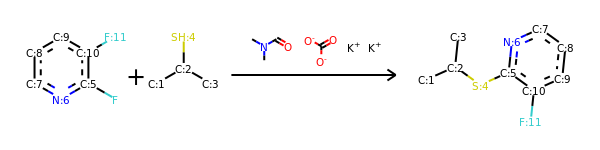

In [ ]:
AllChem.ReactionFromSmarts(atom_mapped_rxn, useSmiles=True)

In [ ]:
assert canonical_rxn == process_reaction(atom_mapped_rxn)

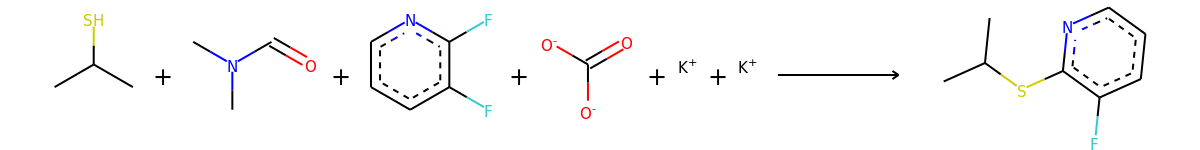

In [ ]:
AllChem.ReactionFromSmarts(canonical_rxn, useSmiles=True)

`SmilesTokenizer` splits the reaction SMILES into tokens.

In [ ]:
tokenizer = get_default_tokenizer()
assert isinstance(tokenizer, SmilesTokenizer)
basic_tokenizer = BasicSmilesTokenizer()

In [ ]:
assert tokenized_rxn == ' '.join(basic_tokenizer.tokenize(canonical_rxn))